# Objective
* 20190102: 
    * Predict stock price in next day using long short term memory(LSTM)
    * Given prices for the last N days, we do prediction for day N+1
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)
    * Here we use MinMaxScalar to fit_transform the train set, which we then use to transform the test set

In [63]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
#### Input params ##################
stk_path = "./rb000.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 5                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=128                  # lstm param. initial value before tuning.
dropout_prob=1                 # lstm param. initial value before tuning.
optimizer='nadam'               # lstm param. initial value before tuning.
epochs=30                       # lstm param. initial value before tuning.
batch_size=8                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelhybju
#########hybju##################

# Set seehybjuure same output results
seed(101)
set_random_seed(model_seed)

# Common functions

In [64]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv_scaled, \
                          scaler, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv_scaled     : actual value of the predictions (scaled)
        scaler          : scaler that is used to fit_transform train set
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = scaler.inverse_transform(est_scaled)
    
    # Get correct scale of y_cv
    y_cv = scaler.inverse_transform(y_cv_scaled)

    # Calculate RMSE and MAPE
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

# Load data

In [65]:
df = pd.read_csv(stk_path, sep = ",")
# Convert Date column to datetime
df.loc[:, 'da te'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,amount_,volume,position,month
0,2009-03-27,3550,3663,3513,3561,12684.25,354590,45548,3
1,2009-03-30,3550,3580,3528,3544,5151.45,145168,48380,3
2,2009-03-31,3538,3566,3531,3549,2506.00,70592,44714,3
3,2009-04-01,3560,3561,3543,3547,997.52,28100,42076,4
4,2009-04-02,3545,3548,3456,3473,8197.17,235446,68888,4


Text(0, 0.5, 'USD')

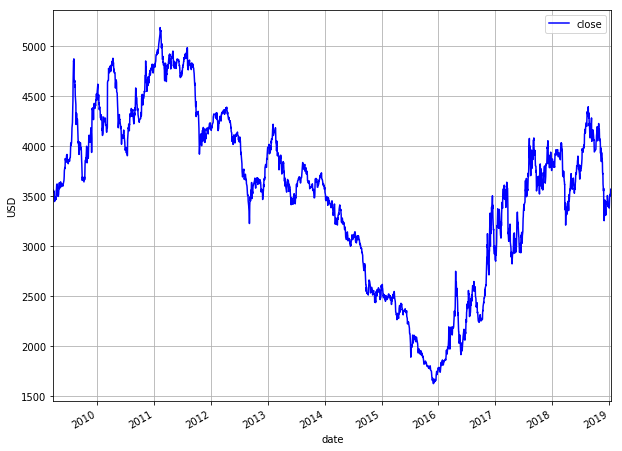

In [66]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Split into train, dev and test sets

We use lags up to N number of days to use as features.

In [67]:
# Get sizes of each of the datasets
print("df:", df)
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train][['date', 'close']]
cv = df[num_train:num_train+num_cv][['date', 'close']]
train_cv = df[:num_train+num_cv][['date', 'close']]
test = df[num_train+num_cv:][['date', 'close']]
print("train:", train)

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

df:            date  open  high   low  close    amount_   volume  position  month
0    2009-03-27  3550  3663  3513   3561   12684.25   354590     45548      3
1    2009-03-30  3550  3580  3528   3544    5151.45   145168     48380      3
2    2009-03-31  3538  3566  3531   3549    2506.00    70592     44714      3
3    2009-04-01  3560  3561  3543   3547     997.52    28100     42076      4
4    2009-04-02  3545  3548  3456   3473    8197.17   235446     68888      4
5    2009-04-03  3481  3481  3436   3448    5266.92   152376     75038      4
6    2009-04-07  3410  3518  3410   3491    8447.99   242578    100482      4
7    2009-04-08  3480  3491  3456   3463    5110.33   147288     91910      4
8    2009-04-09  3476  3486  3460   3468    3045.15    87688     94832      4
9    2009-04-10  3483  3499  3470   3484    4216.23   120978    100164      4
10   2009-04-13  3485  3493  3464   3469    3823.17   109820    109430      4
11   2009-04-14  3475  3600  3469   3560   19237.92   540646

In [68]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = MinMaxScaler(feature_range=(0, 1))
print("train['close']",train['close'])
train_scaled = scaler.fit_transform(np.array(train['close']).reshape(-1,1))
print("scaler.data_min_ = " + str(scaler.data_min_))
print("scaler.data_max_ = " + str(scaler.data_max_))
print("train_scaled",train_scaled)
# Split into x and y
x_train, y_train = get_x_y(train_scaled, N, N)
print("x_train.shape = " + str(x_train.shape)) # (446, 7, 1)
print("y_train.shape = " + str(y_train.shape)) # (446, 1)
print("x_train",x_train)
print("y_train",y_train)
# x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) # (446, 7, 1)
# print("x_train.shape = " + str(x_train.shape))

train['close'] 0       3561
1       3544
2       3549
3       3547
4       3473
5       3448
6       3491
7       3463
8       3468
9       3484
10      3469
11      3560
12      3562
13      3596
14      3620
15      3623
16      3524
17      3526
18      3513
19      3501
20      3499
21      3507
22      3520
23      3553
24      3636
25      3577
26      3594
27      3593
28      3614
29      3639
        ... 
1404    2585
1405    2579
1406    2557
1407    2502
1408    2511
1409    2487
1410    2519
1411    2510
1412    2516
1413    2488
1414    2472
1415    2479
1416    2484
1417    2450
1418    2455
1419    2474
1420    2507
1421    2498
1422    2492
1423    2474
1424    2467
1425    2472
1426    2496
1427    2478
1428    2489
1429    2490
1430    2489
1431    2514
1432    2524
1433    2521
Name: close, Length: 1434, dtype: int64


c:\programdata\miniconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


scaler.data_min_ = [2437.]
scaler.data_max_ = [5188.]
train_scaled [[0.4085787 ]
 [0.40239913]
 [0.40421665]
 ...
 [0.02798982]
 [0.03162486]
 [0.03053435]]
x_train.shape = (1429, 5, 1)
y_train.shape = (1429, 1)
x_train [[[0.4085787 ]
  [0.40239913]
  [0.40421665]
  [0.40348964]
  [0.37659033]]

 [[0.40239913]
  [0.40421665]
  [0.40348964]
  [0.37659033]
  [0.36750273]]

 [[0.40421665]
  [0.40348964]
  [0.37659033]
  [0.36750273]
  [0.38313341]]

 ...

 [[0.02144675]
  [0.01490367]
  [0.01890222]
  [0.01926572]
  [0.01890222]]

 [[0.01490367]
  [0.01890222]
  [0.01926572]
  [0.01890222]
  [0.02798982]]

 [[0.01890222]
  [0.01926572]
  [0.01890222]
  [0.02798982]
  [0.03162486]]]
y_train [[0.36750273]
 [0.38313341]
 [0.37295529]
 ...
 [0.02798982]
 [0.03162486]
 [0.03053435]]


In [69]:
# Scale the cv dataset according the min and max obtained from train set
train_cv_scaled  = scaler.transform(np.array(train_cv['close']).reshape(-1,1))
print(train_cv_scaled)
    # Split into x and y
x_cv, y_cv = get_x_y(train_cv_scaled, N, num_train)
print("x_cv.shape = " + str(x_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))

[[0.4085787 ]
 [0.40239913]
 [0.40421665]
 ...
 [0.24572883]
 [0.2344602 ]
 [0.26463104]]
x_cv.shape = (477, 5, 1)
y_cv.shape = (477, 1)


In [70]:
# Here we scale the train_cv set, for the final model
scaler_final = MinMaxScaler(feature_range=(0, 1))
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['close']).reshape(-1,1))
print("scaler_final.data_min_ = " + str(scaler_final.data_min_))
print("scaler_final.data_max_ = " + str(scaler_final.data_max_))

# Scale the test dataset according the min and max obtained from train_cv set
test_scaled  = scaler_final.transform(np.array(df['close']).reshape(-1,1))
print(test_scaled)

c:\programdata\miniconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


scaler_final.data_min_ = [1626.]
scaler_final.data_max_ = [5188.]
[[0.54323414]
 [0.53846154]
 [0.53986524]
 ...
 [0.54716451]
 [0.53144301]
 [0.53396968]]


# Create and fit the LSTM network

In [71]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/30
 - 6s - loss: 0.0078
Epoch 2/30
 - 2s - loss: 0.0015
Epoch 3/30
 - 2s - loss: 0.0019
Epoch 4/30
 - 2s - loss: 0.0013
Epoch 5/30
 - 2s - loss: 0.0014
Epoch 6/30
 - 2s - loss: 0.0011
Epoch 7/30
 - 2s - loss: 0.0011
Epoch 8/30
 - 2s - loss: 8.7630e-04
Epoch 9/30
 - 2s - loss: 7.4517e-04
Epoch 10/30
 - 2s - loss: 8.2992e-04
Epoch 11/30
 - 2s - loss: 7.7538e-04
Epoch 12/30
 - 2s - loss: 5.7770e-04
Epoch 13/30
 - 2s - loss: 6.2329e-04
Epoch 14/30
 - 2s - loss: 6.0312e-04
Epoch 15/30
 - 2s - loss: 5.5855e-04
Epoch 16/30
 - 2s - loss: 4.4303e-04
Epoch 17/30
 - 2s - loss: 5.2045e-04
Epoch 18/30
 - 2s - loss: 4.2797e-04
Epoch 19/30
 - 2s - loss: 4.1095e-04
Epoch 20/30
 - 2s - loss: 4.3411e-04
Epoch 21/30
 - 2s - loss: 3.8414e-04
Epoch 22/30
 - 3s - loss: 4.4181e-04
Epoch 23/30
 - 3s - loss: 4.1276e-04
Epoch 24/30
 - 2s - loss: 4.2417e-04
Epoch 25/30
 - 2s - loss: 4.1342e-04
Epoch 26/30
 - 2s - loss: 3.4063e-04
Epoch 27/30
 - 2s - loss: 3.9423e-04
Epoch 28/30
 - 3s - loss: 3.5450e-04
E

In [72]:
# Print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 128)            66560     
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Plot model and save to file
plot_model(model, to_file='model.png')

# Predict on dev set

        date  open  high   low  close   amount_   volume  position  month  \
0 2015-02-25  2513  2514  2475   2483  22174.66   890868   1463886      2   
1 2015-02-26  2486  2509  2485   2505  21547.60   863160   1547910      2   
2 2015-02-27  2510  2510  2462   2464  34286.90  1378260   1612236      2   
3 2015-03-02  2462  2483  2426   2472  68041.34  2769934   1673788      3   
4 2015-03-03  2466  2482  2452   2468  29596.43  1199714   1592766      3   

    pred_close  real_close  
0  2511.515625      2483.0  
1  2475.235840      2505.0  
2  2491.587646      2464.0  
3  2459.100342      2472.0  
4  2460.311279      2468.0  
RMSE = 55.166
MAPE = 1.532%


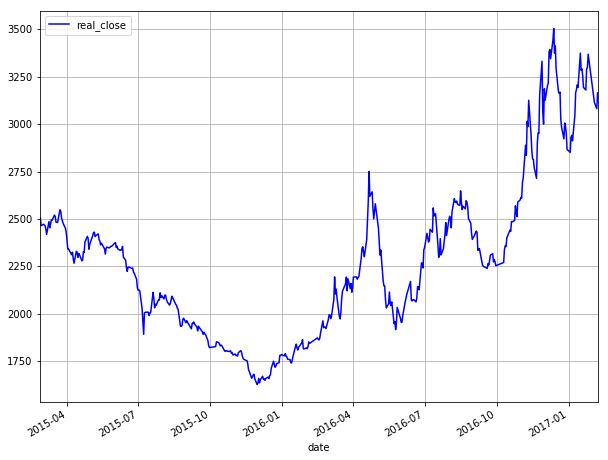

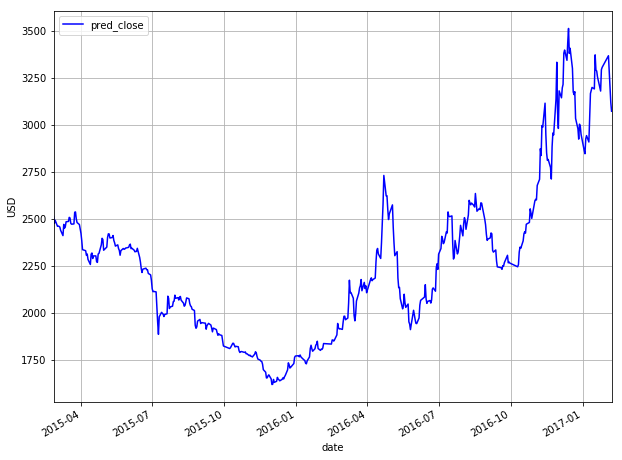

In [73]:
# Do prediction
est = model.predict(x_cv)
est_inv = scaler.inverse_transform(est)

# Get correct scale of y_cv
y_cv_inv = scaler.inverse_transform(y_cv)

df2 = pd.DataFrame(np.hstack((est_inv,y_cv_inv)), columns={"pred_close","real_close"})
df2 = pd.concat([df[num_train:num_train+num_cv].reset_index(drop=True), df2], axis=1)
df2.to_csv("pred_data.csv")
print(df2.head())

rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = df2.plot(x='date', y='real_close', style='b-', grid=True)
ax = df2.plot(x='date', y='pred_close', style='b', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv_inv, est_inv))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv_inv, est_inv)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

Text(0, 0.5, 'USD')

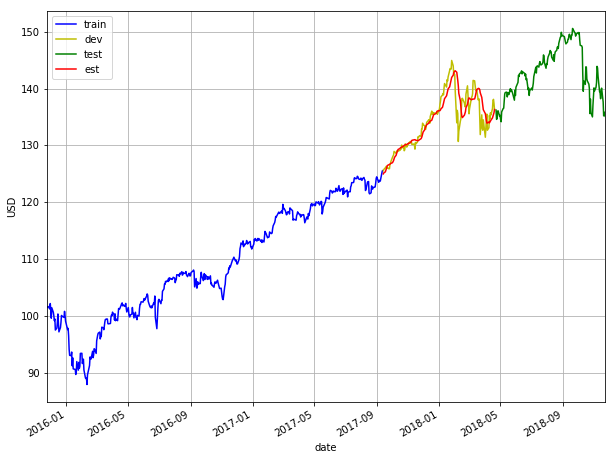

In [13]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est_inv': est_inv.reshape(-1), 
                       'y_cv_inv': y_cv_inv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est_inv', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
    

# Tuning N (no. of days to use as features)

In [14]:
param_label = 'N'
param_list = range(2, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv_scaled = get_x_y(train_cv_scaled, param, num_train)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv_scaled, \
                                          scaler, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer='adam', \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 37.308310564359026


,N,rmse,mape_pct
0,2,3.400263,2.064098
1,3,4.959194,3.346245
2,4,2.466374,1.221967
3,5,1.923283,1.012599
4,6,6.358751,4.454986
5,7,3.385069,1.976944
6,8,2.690280,1.654124
7,9,2.482548,1.507671
8,10,5.808370,3.923370
9,11,3.321405,2.185052


Text(0, 0.5, 'RMSE/MAPE(%)')

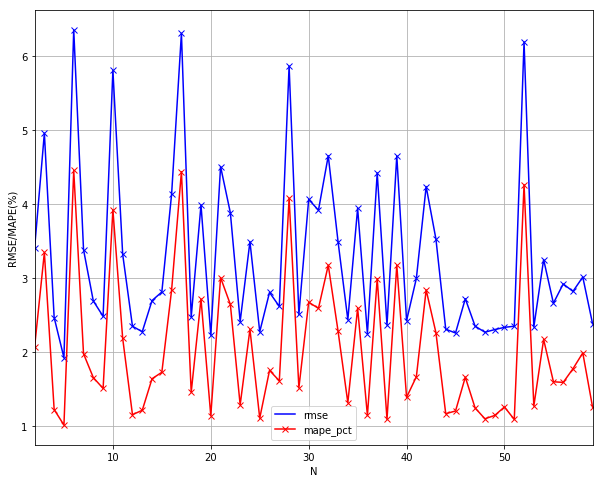

In [15]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [16]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 1.923
min MAPE = 1.013%
optimum N = 5


# Tuning model - epochs and batch_size

In [17]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv_scaled = get_x_y(train_cv_scaled, N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv_scaled, \
                                              scaler, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer='adam', \
                                              epochs=param, \
                                              batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 75.52254137595494


,epochs,batch_size,rmse,mape_pct
0,1,8,3.475563,2.302557
1,1,16,1.897913,1.059061
2,1,32,13.061261,9.501036
3,1,64,35.053016,25.875440
4,1,128,41.932591,30.981785
5,10,8,1.904582,1.002477
6,10,16,2.377222,1.157922
7,10,32,2.988943,1.615738
8,10,64,3.798084,2.603562
9,10,128,8.404959,6.028261


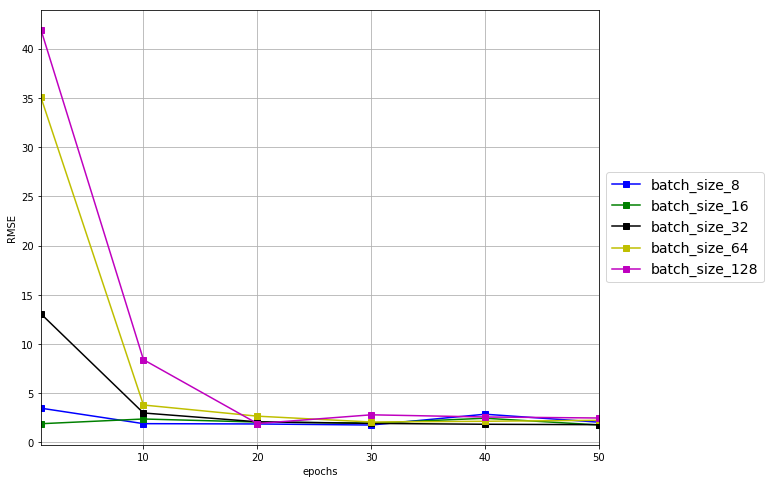

In [18]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 1.764
min MAPE = 0.885%
optimum epochs = 30
optimum batch_size = 8


# Tuning model - LSTM units and dropout prob

In [ ]:
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv_scaled, \
                                              scaler, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer='adam', \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Minutes taken = 1152.114910320441


,lstm_units,dropout_prob,rmse,mape_pct
0,10,0.5,3.666756,2.506646
1,10,0.6,4.421422,2.991757
2,10,0.7,6.542300,4.612238
3,10,0.8,7.832423,5.608776
4,10,0.9,16.279120,11.815458
5,10,1.0,3.435536,2.125523
6,50,0.5,3.396740,2.244762
7,50,0.6,3.671521,2.460263
8,50,0.7,1.925026,1.013891
9,50,0.8,3.828452,2.577045


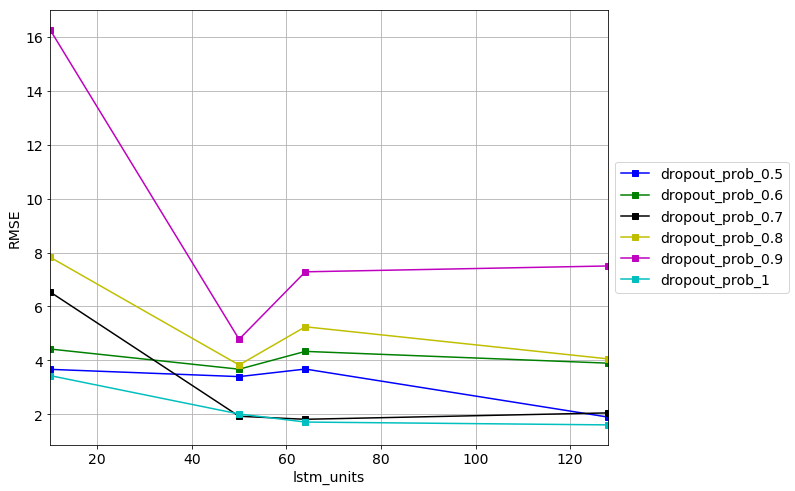

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 1.605
min MAPE = 0.762%
optimum lstm_units = 128
optimum dropout_prob = 1.0


# Tuning model - optimizer

In [ ]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv_scaled, \
                                              scaler, \
                                              lstm_units=lstm_units_opt, \
                                              dropout_prob=dropout_prob_opt, \
                                              optimizer=param, \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

In [ ]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

# Tuned params

In [ ]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

# Final model

In [ ]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test_scaled = get_x_y(test_scaled, N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test_scaled, \
                                        scaler_final, \
                                        lstm_units=lstm_units_opt, \
                                        dropout_prob=dropout_prob_opt, \
                                        optimizer=optimizer_opt, \
                                        epochs=epochs_opt, \
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 1), date(2018, 11, 30)])
ax.set_ylim([130, 155])
ax.set_title("Zoom in to test set")

# Findings
* On the test set, the RMSE is 2.988 and MAPE is 1.886% using N_opt=5